<a href="https://colab.research.google.com/github/MilburnJ/FathomNetScaling/blob/main/FathomNetScalingPerformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [ ]:
!pip install torch torchvision opencv-python matplotlib tqdm fathomnet pascal-voc-writer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
from fathomnet.api import boundingboxes

def find_classes_by_keywords(keywords):
    """
    Find classes in the FathomNet database that match specific keywords.

    Parameters:
        keywords (List[str]): List of keywords to search for in class names.
        auth_header (AuthHeader): Authentication header for API requests.

    Returns:
        Dict[str, List[str]]: Dictionary with keywords as keys and matching classes as values.
    """
    # Fetch all concepts from the database
    all_concepts = boundingboxes.find_concepts()
    print(f"Retrieved {len(all_concepts)} concepts from the database.")

    # Dictionary to store results for each keyword
    results = {keyword: {} for keyword in keywords}

    # Search for keywords in concept names
    for concept in all_concepts:
        for keyword in keywords:
            if keyword.lower() in concept.lower():  # Case-insensitive search
                    # Use `count_by_concept` to get bounding box count for the concept
                    bbox_count = boundingboxes.count_by_concept(concept)
                    print(f"Found {bbox_count} bounding boxes for concept '{concept}'.")

                    # Add the concept and its bounding box count to the results
                    results[keyword][concept] = bbox_count

    return results

# Example usage
keywords = [
            "Anthozoa", #corals
            "Crinoidea", #crinoids
            "Demospongiae", "Hexactinellida", "Calcarea", "Homoscleromorpha", #sponges
            "Agnatha","Chondrichthyes","Osteichthyes","Sarcopterygii","Actinopterygii" #fishes
            ]
x_api_key_token = ""  # Replace with your actual API key
auth_header = auth(x_api_key_token)

matching_classes = find_classes_by_keywords(keywords)

# Print the results
for keyword, classes in matching_classes.items():
    print(f"\nClasses matching '{keyword}': {len(classes)} entries")
    for class_name in classes:
        print(f"- {class_name}")


Retrieved 2414 concepts from the database.
Found ByConceptCount(concept='Actinopterygii', count=363) bounding boxes for concept 'Actinopterygii'.
Found ByConceptCount(concept='Anthozoa', count=79) bounding boxes for concept 'Anthozoa'.
Found ByConceptCount(concept='Crinoidea', count=2228) bounding boxes for concept 'Crinoidea'.
Found ByConceptCount(concept='Demospongiae', count=49) bounding boxes for concept 'Demospongiae'.
Found ByConceptCount(concept='Demospongiae sp. 1', count=13) bounding boxes for concept 'Demospongiae sp. 1'.
Found ByConceptCount(concept='Hexactinellida', count=3501) bounding boxes for concept 'Hexactinellida'.
Found ByConceptCount(concept='Hexactinellida sp. 1', count=13) bounding boxes for concept 'Hexactinellida sp. 1'.
Found ByConceptCount(concept='Hexactinellida sp. 2', count=13) bounding boxes for concept 'Hexactinellida sp. 2'.
Found ByConceptCount(concept='Hexactinellida sp. 3', count=8) bounding boxes for concept 'Hexactinellida sp. 3'.
Found ByConceptCo

Ok, so it seems that the relevant classes are Anthozoa, Crinoidea, Demospongiae, Hexactinellida, Osteichthyes, and Actinopterygii

In [ ]:
import os
import random
from urllib.request import urlretrieve
from fathomnet.api import images, boundingboxes
from pascal_voc_writer import Writer
from tqdm import tqdm

# Directory to save downloaded images and annotations
output_dir = "/content/drive/My Drive/FathomNet_10k"
os.makedirs(output_dir, exist_ok=True)

# Function to download an image
def download_image(image_record, concept_dir):
    url = image_record.url  # Extract the URL
    extension = os.path.splitext(url)[-1]
    image_filename = os.path.join(concept_dir, image_record.uuid + extension)
    urlretrieve(url, image_filename)  # Download the image
    return image_filename

# Function to write an annotation
def write_annotation(image_record, image_filename, concept_dir):
    writer = Writer(image_filename, image_record.width, image_record.height, database="FathomNet")
    for box in image_record.boundingBoxes:
        concept = box.concept
        if box.altConcept:
            concept += f"_{box.altConcept}"
        writer.addObject(concept, box.x, box.y, box.x + box.width, box.y + box.height)
    xml_filename = os.path.join(concept_dir, image_record.uuid + ".xml")
    writer.save(xml_filename)  # Write the annotation

# Function to process a concept
def process_concept(concept, processed_images, concept_dir):
    try:
        # Fetch image records for the concept
        concept_images = images.find_by_concept(concept)
        print(f"Found {len(concept_images)} images for concept '{concept}'.")

        # Download and annotate all available images
        for image_record in concept_images:
            if image_record.uuid not in processed_images:
                image_filename = download_image(image_record, concept_dir)
                write_annotation(image_record, image_filename, concept_dir)
                processed_images.add(image_record.uuid)  # Track processed images
    except Exception as e:
        print(f"Error processing concept '{concept}': {e}")

# Authenticate (replace with your actual API key)
x_api_key_token = "l0RCnV4IWxAtluxuuUnFuMoNh1PpsU"  # Replace with your actual API key
auth_header = auth(x_api_key_token)

# List of top concepts
top_concepts = [
    "Anthozoa",
    "Crinoidea",
    "Demospongiae",
    "Hexactinellida",
    "Osteichthyes",
    "Actinopterygii",
]

# Total images to download
total_images = 10000

# Step 1: Download all images for top concepts
processed_images = set()
for concept in tqdm(top_concepts, desc="Processing Top Concepts"):
    concept_dir = os.path.join(output_dir, concept)
    os.makedirs(concept_dir, exist_ok=True)
    process_concept(concept, processed_images, concept_dir)

# Step 2: Fill remaining images with random concepts
remaining_images = total_images - len(processed_images)
if remaining_images > 0:
    print(f"\nFilling remaining {remaining_images} images with random concepts...")
    all_concepts = boundingboxes.find_concepts()
    random_concepts = [concept for concept in all_concepts if concept not in top_concepts]

    random_dir = os.path.join(output_dir, "RandomConcepts")
    os.makedirs(random_dir, exist_ok=True)

    while remaining_images > 0:
        random.shuffle(random_concepts)
        for concept in random_concepts:
            if remaining_images <= 0:
                break
            process_concept(concept, processed_images, random_dir)
            remaining_images = total_images - len(processed_images)

print("Download and annotation process complete!")


Processing Top Concepts:   0%|          | 0/6 [00:00<?, ?it/s]

Found 38 images for concept 'Anthozoa'.


Processing Top Concepts:  17%|█▋        | 1/6 [00:20<01:42, 20.45s/it]

Found 1222 images for concept 'Crinoidea'.


Processing Top Concepts:  33%|███▎      | 2/6 [14:42<34:21, 515.42s/it]

Found 47 images for concept 'Demospongiae'.


Processing Top Concepts:  50%|█████     | 3/6 [15:07<14:35, 291.74s/it]

Found 1760 images for concept 'Hexactinellida'.


Processing Top Concepts:  67%|██████▋   | 4/6 [38:23<24:14, 727.39s/it]

Found 2 images for concept 'Osteichthyes'.


Processing Top Concepts:  83%|████████▎ | 5/6 [38:24<07:45, 465.72s/it]

Found 320 images for concept 'Actinopterygii'.


Processing Top Concepts: 100%|██████████| 6/6 [43:01<00:00, 430.26s/it]



Filling remaining 6665 images with random concepts...
Found 273 images for concept 'Peniagone sp. 1'.
Found 3 images for concept 'Amperima rosea'.
Found 1 images for concept 'Chaetopterus pugaporcinus'.
Found 158 images for concept 'Ptychogena lactea'.
Found 2 images for concept 'Ophichthus kunaloa'.
Found 2 images for concept 'mucus tube'.
Found 28 images for concept 'Pachycara bulbiceps'.
Found 2 images for concept 'Paragorgia coralloides'.
Found 2 images for concept 'Hexatrygon bickelli'.
Found 118 images for concept 'Mola mola'.
Found 1 images for concept 'Conopora unifacialis'.
Found 2 images for concept 'Cranchia'.
Found 5 images for concept 'Keratoisidinae B1 clade'.
Found 1 images for concept 'Nezumia stelgidolepis'.
Found 1 images for concept 'Aquadopp'.
Found 10 images for concept 'Homerpro'.
Found 1 images for concept 'Spondylus'.
Found 2 images for concept 'Etmopteridae'.
Found 1 images for concept 'Haplomacrourus'.
Found 1 images for concept 'sea star'.
Found 2 images for

Aggregated Category Counts Including Random Concepts:
Sponges: 1758
Corals: 38
Fishes: 318
Crinoids: 1221
Random Concepts: 8188


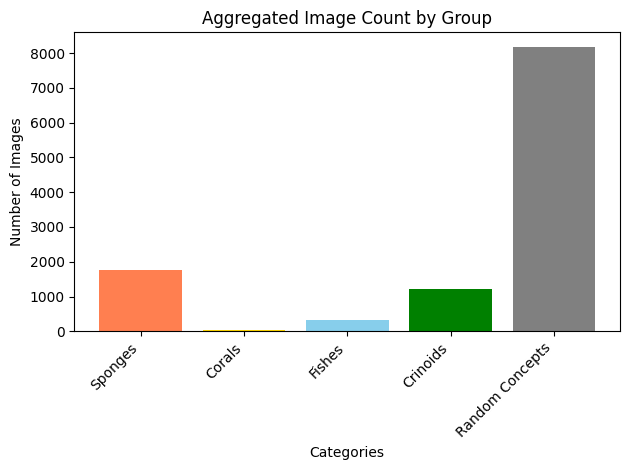

In [ ]:
import os
import matplotlib.pyplot as plt

def get_aggregated_category_counts(main_folder, categories, random_folder_name="RandomConcepts"):

    aggregated_counts = {group: 0 for group in categories}  # Initialize counts for groups

    # Add count for random concepts
    aggregated_counts["Random Concepts"] = 0

    # Iterate over each group and subfolders
    for group, subfolders in categories.items():
        for subfolder in subfolders:
            subfolder_path = os.path.join(main_folder, subfolder)
            if os.path.isdir(subfolder_path):  # Check if subfolder exists
                # Count valid image files
                image_files = [
                    f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                ]
                aggregated_counts[group] += len(image_files)

    # Count images in the random concepts folder
    random_folder_path = os.path.join(main_folder, random_folder_name)
    if os.path.isdir(random_folder_path):
        random_files = [
            f for f in os.listdir(random_folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        aggregated_counts["Random Concepts"] = len(random_files)

    return aggregated_counts


# Define the main folder path and category groups
main_folder = "/content/drive/My Drive/FathomNet_10k"  # Replace with your actual folder path
categories = {
    "Sponges": ["Demospongiae", "Hexactinellida", "Calcarea", "Homoscleromorpha"],
    "Corals": ["Anthozoa"],
    "Fishes": ["Agnatha", "Chondrichthyes", "Osteichthyes", "Sarcopterygii", "Actinopterygii"],
    "Crinoids": ["Crinoidea"]
}

# Get aggregated counts including random concepts
aggregated_counts = get_aggregated_category_counts(main_folder, categories)

# Print aggregated counts
print("Aggregated Category Counts Including Random Concepts:")
for group, count in aggregated_counts.items():
    print(f"{group}: {count}")

# Plot the aggregated counts
plt.bar(aggregated_counts.keys(), aggregated_counts.values(), color=['coral', 'gold', 'skyblue', 'green', 'gray'])
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Aggregated Image Count by Group")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import os
import xml.etree.ElementTree as ET
import imgaug.augmenters as iaa
import cv2
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from tqdm import tqdm

def parse_bounding_boxes(xml_file):
    """
    Parse bounding box coordinates from an XML file.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    object_names = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        object_names.append(name)

    return boxes, object_names, tree

def save_augmented_data(image, bboxes, object_names, xml_tree, save_dir, image_name):
    """
    Save the augmented image and its updated XML file.
    """
    # Save the augmented image
    image_path = os.path.join(save_dir, f"{image_name}.png")
    cv2.imwrite(image_path, image)

    # Update the XML file with new bounding boxes
    root = xml_tree.getroot()
    for obj, bbox in zip(root.findall('object'), bboxes):
        bndbox = obj.find('bndbox')
        bndbox.find('xmin').text = str(int(bbox[0]))
        bndbox.find('ymin').text = str(int(bbox[1]))
        bndbox.find('xmax').text = str(int(bbox[2]))
        bndbox.find('ymax').text = str(int(bbox[3]))

    # Save the updated XML
    xml_path = os.path.join(save_dir, f"{image_name}.xml")
    xml_tree.write(xml_path)

def augment_images_with_bboxes(input_dir, output_dir, augmentations, target_count):
    """
    Augment images and their bounding boxes with progress bars.
    """
    os.makedirs(output_dir, exist_ok=True)

    # List all image files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

    current_count = len(image_files)
    total_to_generate = target_count - current_count

    print(f"Current image count: {current_count}")
    print(f"Target image count: {target_count}")
    print(f"Number of images to generate: {total_to_generate}")

    with tqdm(total=total_to_generate, desc="Augmenting Images", unit="image") as pbar:
        while current_count < target_count:
            for image_file in image_files:
                if current_count >= target_count:
                    break

                # Load the image and corresponding XML file
                image_path = os.path.join(input_dir, image_file)
                xml_path = os.path.join(input_dir, image_file.replace('.png', '.xml'))
                image = cv2.imread(image_path)
                bboxes, object_names, xml_tree = parse_bounding_boxes(xml_path)

                # Convert bounding boxes for augmentation
                ia_bboxes = [BoundingBox(x1=box[0], y1=box[1], x2=box[2], y2=box[3]) for box in bboxes]
                ia_bbs = BoundingBoxesOnImage(ia_bboxes, shape=image.shape)

                # Apply augmentation
                augmented_image, augmented_bbs = augmentations(image=image, bounding_boxes=ia_bbs)

                # Filter out invalid bounding boxes
                augmented_bbs = augmented_bbs.remove_out_of_image().clip_out_of_image()
                augmented_bboxes = [[bb.x1, bb.y1, bb.x2, bb.y2] for bb in augmented_bbs.bounding_boxes]

                # Save augmented data
                save_name = f"aug_{current_count}"
                save_augmented_data(augmented_image, augmented_bboxes, object_names, xml_tree, output_dir, save_name)

                current_count += 1
                pbar.update(1)

def augment_all_categories_in_fathomnet(main_folder, augmentations, target_count):
    """
    Apply augmentation to all subfolders in the FathomNet dataset.

    Parameters:
        main_folder (str): Path to the main FathomNet_10k directory containing subfolders.
        augmentations (iaa.Sequential): Augmentation pipeline.
        target_count (int): Target number of images per category.
    """
    # Iterate through each subfolder in the main folder
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        output_folder = os.path.join(main_folder, f"{subfolder}_augmented")

        # Ensure it's a valid directory
        if os.path.isdir(subfolder_path):
            print(f"\nProcessing category: {subfolder}")
            augment_images_with_bboxes(subfolder_path, output_folder, augmentations, target_count)

# Define main FathomNet_10k directory and augmentation pipeline
main_folder = "/content/drive/My Drive/FathomNet_10k"  # Replace with your FathomNet_10k path
target_count = 2000  # Target number of images per category

augmentations = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-20, 20)),  # Rotate images
    iaa.Multiply((0.8, 1.2)),  # Change brightness
    iaa.Crop(percent=(0, 0.1))  # Random cropping
])

# Apply augmentation to all subfolders
augment_all_categories_in_fathomnet(main_folder, augmentations, target_count)



Processing category: Corals
Current image count: 38
Target image count: 2000
Number of images to generate: 1962


Augmenting Images: 100%|██████████| 1962/1962 [06:23<00:00,  5.12image/s]



Processing category: Crinoids
Current image count: 1212
Target image count: 2000
Number of images to generate: 788


Augmenting Images: 100%|██████████| 788/788 [02:45<00:00,  4.76image/s]



Processing category: RandomConcepts
Current image count: 8149
Target image count: 2000
Number of images to generate: -6149


Augmenting Images: 0image [00:00, ?image/s]



Processing category: Sponges
Current image count: 1754
Target image count: 2000
Number of images to generate: 246


Augmenting Images: 100%|██████████| 246/246 [03:55<00:00,  1.04image/s]



Processing category: Fishes
Current image count: 309
Target image count: 2000
Number of images to generate: 1691


Augmenting Images: 100%|██████████| 1691/1691 [06:55<00:00,  4.07image/s]


In [ ]:
import os
import shutil
from tqdm import tqdm

def move_random_concept_images(source_folder, target_folder, target_count=2000):
    """
    Move a specified number of images and their corresponding XML files
    from the random concepts folder to a new folder.

    Parameters:
        source_folder (str): Path to the source folder (RandomConcepts).
        target_folder (str): Path to the target folder where files will be moved.
        target_count (int): Number of images (and XMLs) to move.
    """
    # Ensure the target folder exists
    os.makedirs(target_folder, exist_ok=True)

    # Get all image files in the source folder
    image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(image_files) < target_count:
        print(f"Warning: Only {len(image_files)} images available. Moving all of them.")
        target_count = len(image_files)

    # Move images and their corresponding XMLs
    for image_file in tqdm(image_files[:target_count], desc="Moving Files", unit="file"):
        # Define source and destination paths for the image
        image_src_path = os.path.join(source_folder, image_file)
        image_dst_path = os.path.join(target_folder, image_file)

        # Define source and destination paths for the XML
        xml_file = image_file.rsplit('.', 1)[0] + '.xml'
        xml_src_path = os.path.join(source_folder, xml_file)
        xml_dst_path = os.path.join(target_folder, xml_file)

        # Move the image file
        shutil.move(image_src_path, image_dst_path)

        # Move the XML file if it exists
        if os.path.exists(xml_src_path):
            shutil.move(xml_src_path, xml_dst_path)

    print(f"Successfully moved {target_count} images and their XMLs to {target_folder}.")

# Example usage
source_folder = "/content/drive/My Drive/FathomNet_10k/RandomConcepts"  # Path to RandomConcepts folder
target_folder = "/content/drive/My Drive/FathomNet_10k/RandomSubset"  # Path to the new folder
target_count = 2000  # Number of images and XMLs to move

move_random_concept_images(source_folder, target_folder, target_count)


Moving Files: 100%|██████████| 2000/2000 [00:10<00:00, 195.49file/s]

Successfully moved 2000 images and their XMLs to /content/drive/My Drive/FathomNet_10k/RandomSubset.


In [ ]:
import os
import shutil
from tqdm import tqdm

def move_augmented_images_to_original(main_folder, classes):
    """
    Moves images and XML files from augmented class folders to the original class folders.

    Parameters:
        main_folder (str): Path to the main directory containing class folders.
        classes (list): List of class names.
    """
    for class_name in classes:
        # Define paths for the original and augmented folders
        original_folder = os.path.join(main_folder, class_name)
        augmented_folder = os.path.join(main_folder, f"{class_name}_augmented")

        # Ensure both folders exist
        if not os.path.isdir(original_folder):
            print(f"Original folder '{original_folder}' does not exist. Skipping...")
            continue
        if not os.path.isdir(augmented_folder):
            print(f"Augmented folder '{augmented_folder}' does not exist. Skipping...")
            continue

        # Get all files in the augmented folder
        augmented_files = os.listdir(augmented_folder)

        # Move files from augmented to original folder
        print(f"Moving files from {augmented_folder} to {original_folder}...")
        for file_name in tqdm(augmented_files, desc=f"Processing {class_name}", unit="file"):
            src_path = os.path.join(augmented_folder, file_name)
            dest_path = os.path.join(original_folder, file_name)
            shutil.move(src_path, dest_path)

        print(f"Finished moving files for class '{class_name}'.")

# Define the main folder and class names
main_folder = "/content/drive/My Drive/FathomNet_10k"  # Replace with your main directory path
classes = ["Fishes", "Sponges", "Corals", "Crinoids"]  # List of class names

# Execute the script
move_augmented_images_to_original(main_folder, classes)


Moving files from /content/drive/My Drive/FathomNet_10k/Fishes_augmented to /content/drive/My Drive/FathomNet_10k/Fishes...


Processing Fishes: 100%|██████████| 3382/3382 [00:07<00:00, 446.48file/s]


Finished moving files for class 'Fishes'.
Moving files from /content/drive/My Drive/FathomNet_10k/Sponges_augmented to /content/drive/My Drive/FathomNet_10k/Sponges...


Processing Sponges: 100%|██████████| 492/492 [00:01<00:00, 410.45file/s]


Finished moving files for class 'Sponges'.
Moving files from /content/drive/My Drive/FathomNet_10k/Corals_augmented to /content/drive/My Drive/FathomNet_10k/Corals...


Processing Corals: 100%|██████████| 3924/3924 [00:09<00:00, 414.82file/s]


Finished moving files for class 'Corals'.
Moving files from /content/drive/My Drive/FathomNet_10k/Crinoids_augmented to /content/drive/My Drive/FathomNet_10k/Crinoids...


Processing Crinoids: 100%|██████████| 1576/1576 [00:03<00:00, 403.47file/s]

Finished moving files for class 'Crinoids'.


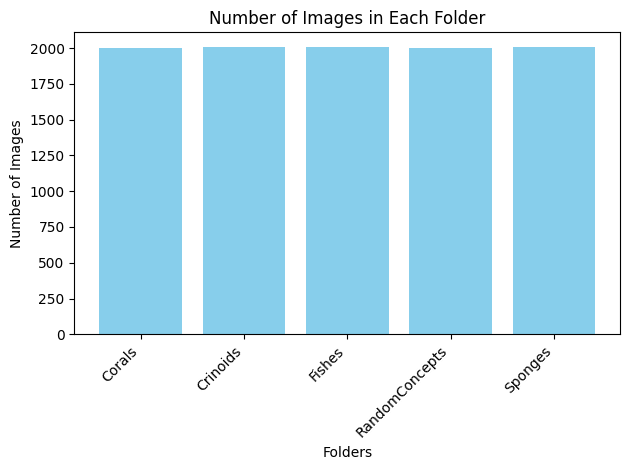

Image Counts per Folder:
Corals: 2000 images
Crinoids: 2009 images
Fishes: 2009 images
RandomConcepts: 2000 images
Sponges: 2004 images


In [ ]:
import os
import matplotlib.pyplot as plt

def plot_image_counts_in_folders(main_folder):
    """
    Plot the number of images in each folder within the main directory.

    Parameters:
        main_folder (str): Path to the main directory containing class folders.
    """
    folder_counts = {}

    # Iterate through each folder in the main directory
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        if os.path.isdir(folder_path):  # Check if it's a folder
            # Count the number of valid image files in the folder
            image_files = [
                f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            folder_counts[folder] = len(image_files)

    # Sort the counts by folder name for consistent plotting
    folder_counts = dict(sorted(folder_counts.items()))

    # Plot the results
    plt.bar(folder_counts.keys(), folder_counts.values(), color='skyblue')
    plt.xlabel("Folders")
    plt.ylabel("Number of Images")
    plt.title("Number of Images in Each Folder")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print counts for reference
    print("Image Counts per Folder:")
    for folder, count in folder_counts.items():
        print(f"{folder}: {count} images")

# Define the main folder path
main_folder = "/content/drive/My Drive/FathomNet_10k"  # Replace with your main directory path

# Execute the function
plot_image_counts_in_folders(main_folder)


Displaying image: /content/drive/My Drive/FathomNet_10k/Corals/aug_992.png
Using XML: /content/drive/My Drive/FathomNet_10k/Corals/aug_992.xml


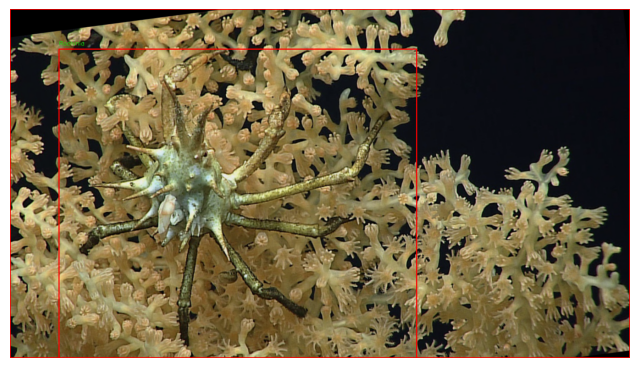

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def parse_bounding_boxes_from_xml(xml_file):
    """
    Parse bounding boxes and labels from an XML file.

    Parameters:
        xml_file (str): Path to the XML file.

    Returns:
        list: List of bounding boxes in the format [xmin, ymin, xmax, ymax].
        list: List of corresponding labels (names) for the bounding boxes.
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bounding_boxes = []
    labels = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bounding_boxes.append([xmin, ymin, xmax, ymax])
        labels.append(name)

    return bounding_boxes, labels

def display_image_with_bounding_boxes(image_path, bounding_boxes, labels):
    """
    Display an image with its bounding boxes and labels overlaid.

    Parameters:
        image_path (str): Path to the image file.
        bounding_boxes (list): List of bounding boxes in the format [xmin, ymin, xmax, ymax].
        labels (list): List of labels corresponding to the bounding boxes.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Draw bounding boxes and labels on the image
    for bbox, label in zip(bounding_boxes, labels):
        xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=2)
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def pick_random_image_and_display(main_folder):
    """
    Pick a random image and its corresponding XML file from a random folder in FathomNet_10k
    and display the image with its bounding boxes and labels.

    Parameters:
        main_folder (str): Path to the main folder containing class folders.
    """
    # Get a list of subfolders in the main folder
    subfolders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

    # Pick a random subfolder
    random_subfolder = random.choice(subfolders)
    random_subfolder_path = os.path.join(main_folder, random_subfolder)

    # Get a list of image files in the subfolder
    image_files = [f for f in os.listdir(random_subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in the folder: {random_subfolder}")
        return

    # Pick a random image
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(random_subfolder_path, random_image_file)

    # Get the corresponding XML file
    xml_file = random_image_file.rsplit('.', 1)[0] + '.xml'
    xml_path = os.path.join(random_subfolder_path, xml_file)
    if not os.path.exists(xml_path):
        print(f"No XML file found for the image: {random_image_file}")
        return

    # Parse bounding boxes and labels from the XML file
    bounding_boxes, labels = parse_bounding_boxes_from_xml(xml_path)

    # Display the image with its bounding boxes and labels
    print(f"Displaying image: {random_image_path}")
    print(f"Using XML: {xml_path}")
    display_image_with_bounding_boxes(random_image_path, bounding_boxes, labels)

# Example usage
main_folder = "/content/drive/My Drive/FathomNet_10k"  # Replace with your FathomNet_10k folder path
pick_random_image_and_display(main_folder)


In [ ]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm


In [ ]:
# Define your class mapping
categories = {
    "Sponges": ["Demospongiae", "Hexactinellida", "Calcarea", "Homoscleromorpha"],
    "Corals": ["Anthozoa"],
    "Fishes": ["Agnatha", "Chondrichthyes", "Osteichthyes", "Sarcopterygii", "Actinopterygii"],
    "Crinoids": ["Crinoidea"],
}
class_mapping = {name: idx for idx, name in enumerate(categories)}


In [ ]:
import torchvision.transforms.functional as F

class CustomVOCDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, class_mapping, transforms=None, target_size=(512, 512)):
        """
        Custom Dataset for Faster R-CNN with resizing.

        Parameters:
            image_paths (List[str]): List of paths to images.
            annotation_paths (List[str]): List of paths to corresponding XML annotations.
            class_mapping (dict): Mapping from class names to numerical labels.
            transforms (callable, optional): Transformations to apply to images.
            target_size (Tuple[int, int]): Desired output size for the images (width, height).
        """
        assert len(image_paths) == len(annotation_paths), "Images and annotations must have the same length"
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.class_mapping = class_mapping
        self.transforms = transforms
        self.target_size = target_size

    def parse_xml(self, xml_path):
        """
        Parse XML annotations and ensure consistency between boxes and labels.
        """
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            boxes = []
            labels = []

            for obj in root.findall("object"):
                name = obj.find("name").text
                category = next((key for key, values in categories.items() if name in values), None)
                if category is None:
                    continue  # Skip if not in target categories

                label = self.class_mapping[category]
                bndbox = obj.find("bndbox")
                xmin = int(float(bndbox.find("xmin").text))
                ymin = int(float(bndbox.find("ymin").text))
                xmax = int(float(bndbox.find("xmax").text))
                ymax = int(float(bndbox.find("ymax").text))

                # Only add valid bounding boxes
                if xmax > xmin and ymax > ymin:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(label)

            # Ensure boxes and labels match
            if len(boxes) != len(labels):
                print(f"Mismatch in boxes and labels for {xml_path}. Skipping.")
                return {"boxes": torch.tensor([]), "labels": torch.tensor([])}

            return {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
            }
        except Exception as e:
            print(f"Error parsing XML file {xml_path}: {e}")
            return {"boxes": torch.tensor([]), "labels": torch.tensor([])}


    def resize_image_and_boxes(self, image, boxes):
        """
        Resize the image and adjust bounding boxes proportionally.

        Parameters:
            image (PIL.Image.Image): The input image.
            boxes (torch.Tensor): Bounding boxes in the format [xmin, ymin, xmax, ymax].

        Returns:
            image (torch.Tensor): The resized image as a tensor.
            boxes (torch.Tensor): Adjusted bounding boxes.
        """
        original_width, original_height = image.size
        new_width, new_height = self.target_size

        # Resize image
        image = F.resize(image, (new_height, new_width))

        # Scale bounding boxes
        if boxes.numel() > 0:  # Check if there are any boxes
            x_scale = new_width / original_width
            y_scale = new_height / original_height
            boxes[:, [0, 2]] *= x_scale  # Scale xmin and xmax
            boxes[:, [1, 3]] *= y_scale  # Scale ymin and ymax

        # Convert image to tensor
        image = F.to_tensor(image)

        return image, boxes


    def __getitem__(self, idx):
        while True:  # Loop until a valid annotation is found
            image_path = self.image_paths[idx]
            xml_path = self.annotation_paths[idx]

            try:
                # Load image
                image = Image.open(image_path).convert("RGB")

                # Parse annotations
                target = self.parse_xml(xml_path)

                # Resize image and bounding boxes
                image, target["boxes"] = self.resize_image_and_boxes(image, target["boxes"])

                # Apply additional transformations if provided
                if self.transforms:
                    image = self.transforms(image)

                # Check for valid bounding boxes
                if target["boxes"].shape[0] > 0:
                    return image, target
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

            # Move to the next image if current one is invalid
            idx = (idx + 1) % len(self.image_paths)

    def __len__(self):
        return len(self.image_paths)


In [ ]:
def load_multiple_folders(root_dir, class_mapping):
    """
    Collect images and their annotations from multiple subfolders.

    Parameters:
        root_dir (str): Path to the root directory containing subfolders.
        class_mapping (dict): Mapping of class names to IDs.

    Returns:
        CustomVOCDataset: Dataset object for Faster R-CNN.
    """
    image_paths = []
    annotation_paths = []

    # Traverse all subfolders
    for subfolder in os.listdir(root_dir):
        subfolder_path = os.path.join(root_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(subfolder_path, file))
                    annotation_paths.append(
                        os.path.join(subfolder_path, file.replace(".jpg", ".xml")
                                                   .replace(".jpeg", ".xml")
                                                   .replace(".png", ".xml"))
                    )

    # Ensure all annotation files exist
    valid_image_paths = []
    valid_annotation_paths = []
    for img_path, ann_path in zip(image_paths, annotation_paths):
        if os.path.exists(ann_path):
            valid_image_paths.append(img_path)
            valid_annotation_paths.append(ann_path)

    # Return the dataset
    return CustomVOCDataset(valid_image_paths, valid_annotation_paths, class_mapping)


In [ ]:
import os
from sklearn.model_selection import train_test_split

def prepare_split(root_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Prepare train, val, and test splits for your dataset.

    Parameters:
        root_dir (str): Root directory containing subfolders of images and XMLs.
        train_ratio (float): Ratio of data for training.
        val_ratio (float): Ratio of data for validation.
        test_ratio (float): Ratio of data for testing.

    Returns:
        train_split, val_split, test_split: Lists of (image_path, annotation_path) tuples.
    """
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Train, validation, and test ratios must sum to 1.0.")

    image_paths = []
    annotation_paths = []

    # Traverse all subfolders and collect image/annotation pairs
    for subfolder in os.listdir(root_dir):
        subfolder_path = os.path.join(root_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(subfolder_path, file))
                    annotation_paths.append(
                        os.path.join(subfolder_path, file.replace('.jpg', '.xml')
                                                      .replace('.jpeg', '.xml')
                                                      .replace('.png', '.xml'))
                    )

    # Ensure valid annotations exist
    valid_pairs = [(img, ann) for img, ann in zip(image_paths, annotation_paths) if os.path.exists(ann)]

    # Split dataset
    train_val_split, test_split = train_test_split(valid_pairs, test_size=test_ratio, random_state=42)
    train_split, val_split = train_test_split(train_val_split, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

    print(f"Train: {len(train_split)} images, Val: {len(val_split)} images, Test: {len(test_split)} images")
    return train_split, val_split, test_split



In [ ]:

root_dir = "/content/drive/My Drive/FathomNet_10k"
train_split, val_split, test_split = prepare_split(root_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2)

target_size = (480,270)
# Assume train_split, val_split, and test_split are lists of (image_path, annotation_path) tuples
train_dataset = CustomVOCDataset(
    image_paths=[img for img, ann in train_split],
    annotation_paths=[ann for img, ann in train_split],
    class_mapping=class_mapping,
    target_size=target_size
)

val_dataset = CustomVOCDataset(
    image_paths=[img for img, ann in val_split],
    annotation_paths=[ann for img, ann in val_split],
    class_mapping=class_mapping,
    target_size=target_size
)

test_dataset = CustomVOCDataset(
    image_paths=[img for img, ann in test_split],
    annotation_paths=[ann for img, ann in test_split],
    class_mapping=class_mapping,
    target_size=target_size
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4, pin_memory=True)


Train: 7014 images, Val: 1003 images, Test: 2005 images


In [ ]:
# Define the number of classes (4 classes + 1 background)
num_classes = len(categories) + 1

# Load pretrained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 205MB/s]


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 17.2 MB/s eta 0:00:00


In [ ]:
from google.colab import files


# Move model to device (GPU or CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 3

import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.cuda import memory_allocated, memory_reserved, max_memory_allocated

# Initialize variables to track mAP, training time, and GPU memory
mAP_scores = []
epoch_times = []
gpu_memory_usage = []

# Training Loop
for epoch in range(num_epochs):
    # ---- Training Phase ----
    model.train()
    epoch_loss = 0
    start_time = time.time()  # Start timing the epoch

    # Progress bar for training
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]", leave=True)
    for images, targets in train_pbar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Track GPU memory usage
        gpu_memory_usage.append({
            "current_allocated": memory_allocated(device),
            "current_reserved": memory_reserved(device),
            "max_allocated": max_memory_allocated(device),
        })

        # Update training progress bar
        train_pbar.set_postfix({"Batch Loss": losses.item()})

    # Record training time for the epoch
    end_time = time.time()
    epoch_times.append(end_time - start_time)
    print(f"Epoch {epoch + 1} Training Loss: {epoch_loss:.4f}, Time: {epoch_times[-1]:.2f}s")

    # ---- Validation Phase ----
    model.eval()
    val_loss = 0  # If you need loss tracking in eval mode, handle it separately
    test_metric = MeanAveragePrecision(iou_thresholds=[0.5])

    # Progress bar for validation
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]", leave=True)
    with torch.no_grad():
        for images, targets in val_pbar:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Predictions
            outputs = model(images)  # Predictions in evaluation mode

            # Prepare predictions and ground truths for mAP
            preds = [
                {
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu(),
                }
                for o in outputs
            ]
            gts = [
                {"boxes": t["boxes"].cpu(), "labels": t["labels"].cpu()}
                for t in targets
            ]

            # Update mAP metric
            test_metric.update(preds, gts)

    # Compute mAP
    map_result = test_metric.compute()
    mAP_scores.append(map_result["map_50"].item())  # mAP@0.5
    print(f"Epoch {epoch + 1} Validation mAP@0.5: {mAP_scores[-1]:.4f}")


# ---- Test Phase (Optional) ----
model.eval()
test_metric = MeanAveragePrecision(iou_thresholds=[0.5])  # mAP@0.5print("\nEvaluating on Test Dataset...")
with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Test Dataset Evaluation", leave=True)
    for images, targets in test_pbar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Predictions
        outputs = model(images)

        # Prepare predictions and ground truths for mAP
        preds = [
            {
                "boxes": o["boxes"].cpu(),
                "scores": o["scores"].cpu(),
                "labels": o["labels"].cpu(),
            }
            for o in outputs
        ]
        gts = [
            {"boxes": t["boxes"].cpu(), "labels": t["labels"].cpu()}
            for t in targets
        ]

        # Update test mAP metric
        test_metric.update(preds, gts)

    # Compute test mAP
    test_map_result = test_metric.compute()
    print(f"Test mAP@0.5: {test_map_result['map_50'].item():.4f}")

# Plot Results
# 1. Plot mAP
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs + 1), mAP_scores, marker="o", label="mAP@0.5")
plt.title("Mean Average Precision (mAP@0.5) Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@0.5")
plt.grid()
plt.legend()
plt.show()

# 2. Plot Training Times
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_epochs + 1), epoch_times, marker="o", label="Training Time (s)")
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid()
plt.legend()
plt.show()

# 3. GPU Memory Usage
gpu_memory_allocated = [entry["max_allocated"] / 1e6 for entry in gpu_memory_usage]
plt.figure(figsize=(10, 5))
plt.plot(gpu_memory_allocated, label="Max Allocated GPU Memory (MB)")
plt.title("GPU Memory Usage During Training")
plt.xlabel("Batch")
plt.ylabel("Memory (MB)")
plt.grid()
plt.legend()
plt.show()

torch.save(model.state_dict(), "fasterrcnn_fathomnet10k_480_270.pth")
files.download("fasterrcnn_fathomnet10k_480_270.pth")


Epoch 1/3 [Training]:  58%|█████▊    | 1026/1754 [12:24<08:48,  1.38it/s, Batch Loss=0.163]


KeyboardInterrupt: 

<ipython-input-48-4aade5756e65>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Selected Test Image: /content/drive/My Drive/FathomNet_10k/Crinoids/e3fae8a1-b5ca-4c5c-a4f9-af1766454e67.png


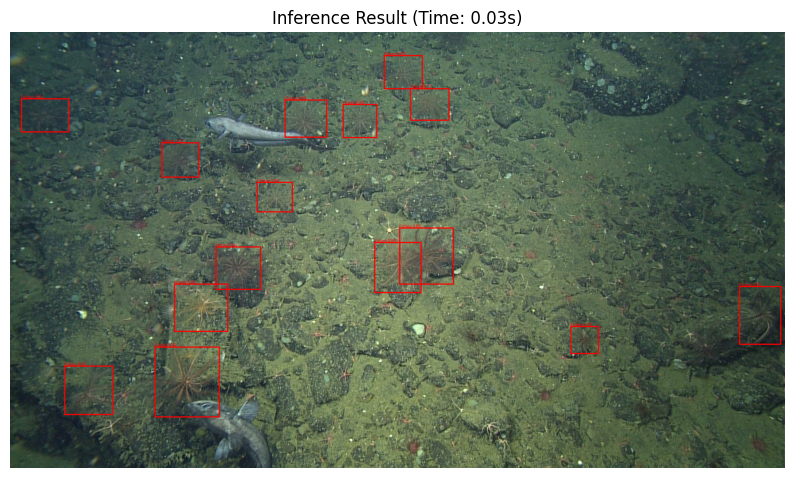

In [ ]:
import os
import torch
import random
from torchvision.transforms.functional import to_tensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import time

# Define your class labels (update based on your class_mapping)
class_labels = ["Background", "Sponges", "Corals", "Fishes", "Crinoids"]

# Load the trained model
model_path = "/content/drive/My Drive/fasterrcnn_fathomnet1k_480_270.pth"
num_classes = len(class_labels)  # Number of classes including background

# Initialize the model and load weights
model = fasterrcnn_resnet50_fpn(num_classes=num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to draw bounding boxes and labels on the image
def draw_boxes(image, predictions, threshold=0.5):
    """
    Draws bounding boxes and labels on an image.

    Parameters:
        image (PIL.Image.Image): The input image.
        predictions (dict): Model predictions with 'boxes', 'labels', and 'scores'.
        threshold (float): Minimum confidence score to display a box.

    Returns:
        PIL.Image.Image: Image with bounding boxes and labels drawn.
    """
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()  # Use default font

    for box, label, score in zip(predictions["boxes"], predictions["labels"], predictions["scores"]):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            label_text = f"{class_labels[label]}: {score:.2f}"
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
            draw.text((xmin, ymin - 10), label_text, fill="red", font=font)

    return image

# Function to select a random test image
def get_random_image(base_dir):
    """
    Select a random image from subfolders in the base directory.

    Parameters:
        base_dir (str): Path to the main folder containing subfolders with images.

    Returns:
        str: Path to the selected random image.
    """
    subfolders = [os.path.join(base_dir, subfolder) for subfolder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, subfolder))]
    random_folder = random.choice(subfolders)
    image_files = [os.path.join(random_folder, f) for f in os.listdir(random_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    return random.choice(image_files)

# Base directory for images (e.g., FathomNet_10k folder)
base_dir = "/content/drive/My Drive/FathomNet_10k"

# Get a random image from the dataset
test_image_path = get_random_image(base_dir)
print(f"Selected Test Image: {test_image_path}")

# Load and preprocess the test image
image = Image.open(test_image_path).convert("RGB")
image_tensor = to_tensor(image).unsqueeze(0).to(device)  # Add batch dimension

# Perform inference and track time
start_time = time.time()
with torch.no_grad():
    predictions = model(image_tensor)
end_time = time.time()
inference_time = end_time - start_time

# Post-process predictions
predictions = predictions[0]  # Get predictions for the first image in the batch
predictions = {
    "boxes": predictions["boxes"].cpu().numpy(),
    "labels": predictions["labels"].cpu().numpy(),
    "scores": predictions["scores"].cpu().numpy(),
}

# Visualize predictions
result_image = draw_boxes(image.copy(), predictions, threshold=0.5)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(result_image)
plt.axis("off")
plt.title(f"Inference Result (Time: {inference_time:.2f}s)")
plt.show()
